# An introduction to probabilistic programming with (Num)Pyro and Jax
## IAIFI Summer School 2022

**Siddharth Mishra-Sharma** (smsharma@mit.edu)


## 1. What is probabilistic programming? <a name="introduction"></a>

### 1.1. Probabilistic modeling as storytelling

- One way to look at defining probabilistic models: telling a story about how you think your data came about
- Many scientific observations of interest can be described in terms of simulators
- Simulators execute a series of stochastic steps to produce a realization of the dataset of interest---**simulators are probabilistic programs**

<img src="https://raw.githubusercontent.com/smsharma/smsharma/master/lhc.png#" alt="LHC Schematic" width="800"/>

$$\theta \sim p(\theta)$$
$$\mathrm{parton} \sim p(\mathrm{parton}\mid\theta)$$
$$\mathrm{shower} \sim p(\mathrm{shower}\mid\mathrm{parton})$$
$$\mathrm{detector} \sim p(\mathrm{detector}\mid\mathrm{shower})$$
$$x \sim p(x\mid \mathrm{detector})$$

After writing our forward model as a probabilistic program, we can then use inference algorithms to 'invert' the process and get the Bayesian posterior $p(\theta\mid x)$ for a given observation

### 1.2. Probabilistic programming languages (PPLs)

- Probabilistic programming languages (PPLs) realize this paradigm by treating (random) variables and distributions as first-class objects, allowing us to
    - Compose probabilistic models in terms of distributions of random variables
    - Perform inference on models by them conditioning on observations

A biased sample of PPLs, with different design philosophies and inference engines:
- [Pyro](https://pyro.ai/)/[NumPyro](https://num.pyro.ai/en/stable/): based on PyTorch/JAX with strengths in variational inference and MCMC respectively
- [PyMC3](https://docs.pymc.io/en/v3/): a solid general-purpose PPL in Python
- [Turing.jl](https://turing.ml/stable/): based on Julia
- [Tensorflow Probability](https://www.tensorflow.org/probability): based on Tensorflow

Being based on differentiable framework, they make it easy to use gradient-based optimization for inference.

In [2]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

color_default = 'firebrick'

from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
! pip install emcee corner pyro-ppl tqdm seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.7 MB/s 
     |████████████████████████████████| 718 kB 19.5 MB/s 


In [1]:
! pip install --upgrade daft

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: daft
    Found existing installation: daft 0.0.4
    Uninstalling daft-0.0.4:
      Successfully uninstalled daft-0.0.4


In [4]:
# Fix seed for reproducibility

import random
import torch
import pyro

SEED = 192

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
pyro.set_rng_seed(SEED)

## 2. A simple example

We will start by playing around with the familiar supernova dataset that we've seen a few time before. Let's download, load and plot it.

In [ ]:
import urllib.request

# Download the SN data file
url = 'https://supernova.lbl.gov/union/figures/SCPUnion2.1_mu_vs_z.txt'
os.makedirs("./data", exist_ok=True)
urllib.request.urlretrieve(url, './data/SCPUnion2.1_mu_vs_z.txt')

('./data/SCPUnion2.1_mu_vs_z.txt', <http.client.HTTPMessage at 0x7fe61352feb0>)

In [ ]:
data = np.genfromtxt('./data/SCPUnion2.1_mu_vs_z.txt')

zs = data.T[1]  # Redshift
mm = data.T[2]  # Difference between apparent and absolute magnitude (distance modulus)
dm = data.T[3]  # Its uncertainty

c = 3e5  # Speed of light

<ErrorbarContainer object of 3 artists>

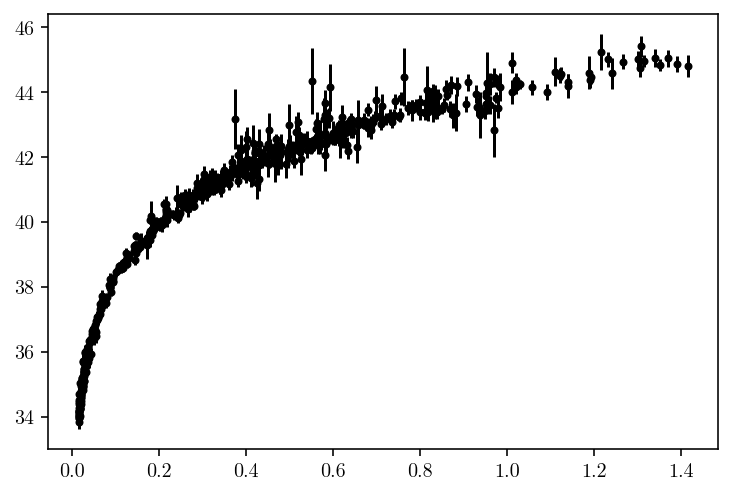

In [ ]:
plt.errorbar(zs, mm, yerr=dm, marker='.', ls='None', color='k')

In [ ]:
print("Dataset consists of {} data points".format(len(mm)))

Dataset consists of 580 data points


As before, we'll use this dataset to infer the hubble parameter $H_0$, as well as an additional parameter $q_0$, historically called the deceleration parameter. $q_0 < 0$ corresponds to an accelerating universe, $q_0 > 0$ a decelerating universe (see https://en.wikipedia.org/wiki/Deceleration_parameter for further details).

The theoretical luminosity distance prediction can be computed as 
$$ d = \frac{c}{H_0}\left(z + \frac{1}{2}(1 - q_0) \, z^2\right)$$

<ErrorbarContainer object of 3 artists>

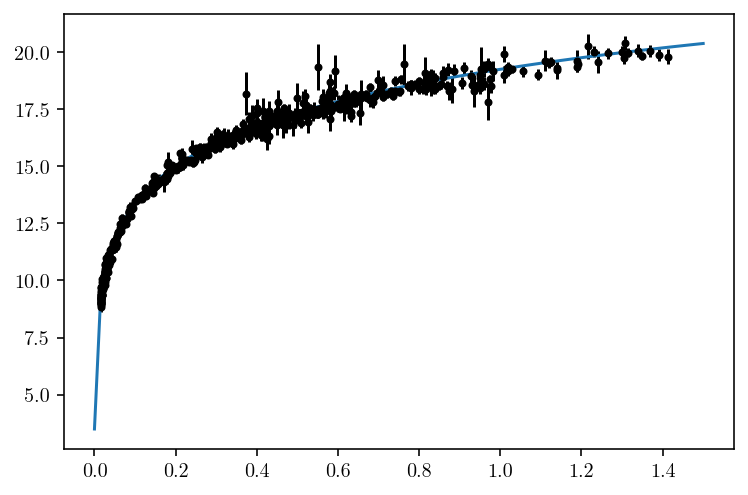

In [ ]:
from scipy.integrate import quad

def H(z, H0=70, OmM=0.3, OmL=0.7):
    return H0 * jnp.sqrt(OmM * (1 + z) ** 3 + OmL)

def dL(z, H0=70, OmM=0.3):
    z_ary = jnp.linspace(0., z, 1000)
    return jnp.trapz(c / H(z_ary, H0, OmM, 1 - OmM), z_ary) * (1 + z)
#     return quad(lambda zp: c / H(zp, H0, OmM, 1 - OmM), 0., z)[0] * (1 + z)

def mu(z, H0=70, OmM=0.3):
    return jnp.log10(dL(z, H0, OmM) + 5.) * 5.

z_ary = np.linspace(0, 1.5, 100)

plt.plot(z_ary, [mu(z, H0=70, OmM=0.2) for z in z_ary])
plt.errorbar(zs, mm - 25, yerr=dm, marker='.', ls='None', color='k')

### 2.1. Weighted least squares

We'll start with a simple weighted least squares approach using `scipy.optimize.minimize`, which should be familiar. We write down a likelihood, and use the optimizer to obtain the maximum-likelihood estimate (MLE) by minimizing the (negative) log-likelihood.

In [ ]:
from scipy.optimize import minimize

In [ ]:
def mu_pred(z, H0, OmM):
    """ Predicted distance modulus
    """
    return np.array([mu(zz, H0, OmM) for zz in z])

In [ ]:
def log_likelihood(theta, x, y, yerr):
    """ Gaussian log-likelihood of dist. mod. given H0 and deceleration parameter q
    """
    H0, OmM = theta
    y_pred = mu_pred(x, H0, OmM) + 25.
    ll = -0.5 * np.sum((y - y_pred) ** 2 / yerr ** 2)
    return ll

In [ ]:
nll = lambda *args: -log_likelihood(*args)
soln = minimize(nll, [30., 0.5], bounds=[[1., 100.],[0., 1.]], args=(zs, mm, dm))
H0_mle, q0_mle = soln.x

print("MLE estimates are H0 = {}, OmM = {}".format(H0_mle, q0_mle))

MLE estimates are H0 = 72.31721120421955, OmM = 0.20371530931456527


## With vmap + jit

In [ ]:
from jax import vmap, jit
mu_pred_vmap = jit(vmap(mu, in_axes=(0,None,None)))

In [ ]:
def log_likelihood_vmap(theta, x, y, yerr):
    """ Gaussian log-likelihood of dist. mod. given H0 and deceleration parameter q
    """
    H0, OmM = theta
    y_pred = mu_pred_vmap(x, H0, OmM) + 25.
    ll = -0.5 * np.sum((y - y_pred) ** 2 / yerr ** 2)
    return ll

In [ ]:
nll = lambda *args: -log_likelihood_vmap(*args)
soln = minimize(nll, [30., 0.5], bounds=[[1., 100.],[0., 1.]], args=(zs, mm, dm))
H0_mle, q0_mle = soln.x

print("MLE estimates are H0 = {}, OmM = {}".format(H0_mle, q0_mle))

MLE estimates are H0 = 71.94845381652367, OmM = 0.21478058648789747


### 2.2. MCMC with `emcee`

Next, we'll do traditional MCMC with `emcee`, which should again be familiar. Here, we draw samples from a log-probability distribution, with the samples then being representative of the joint posterior on the two parameters of interest.

In [ ]:
import emcee
import corner

In [ ]:
def log_prob(theta, x, y, y_err):
        
    H0, q0 = theta
        
    # Prior contribution
    
    lp = 0
    if not 10. < H0 < 100. and not 0. < q0 < 1.:
        lp = -np.inf

    return lp + log_likelihood(theta, x, y, y_err)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers=32, ndim=2, log_prob_fn=log_prob, args=(zs, mm, dm))
pos = soln.x + 1e-4 * np.random.randn(32, 2)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [01:51<00:00, 44.94it/s]


In [ ]:
samples_emcee = sampler.get_chain(discard=1000, thin=15, flat=True)

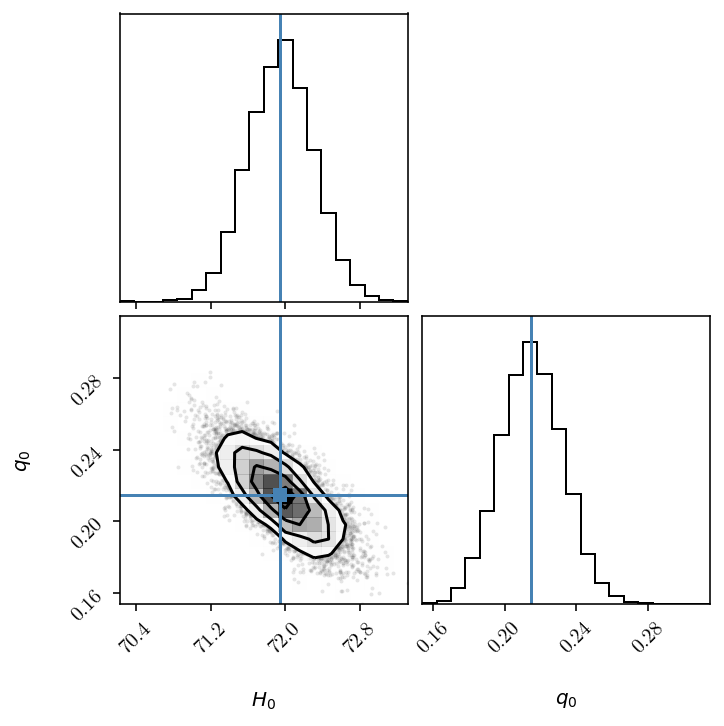

In [ ]:
corner.corner(samples_emcee, truths=soln.x, labels=[r"$H_0$", r"$q_0$"]);

### 2.3. Differentiable probabilistic programming approaches with `Pyro`

In [ ]:
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import SVI, Predictive, Trace_ELBO, autoguide
import numpyro.distributions as dist

from tqdm.notebook import tqdm

Now let's try our hand at the probabilistic programming approach. We will use a probabilistic programming language (PPL) framework called `Pyro`, which derives from `PyTorch`. There are two parts to this whole thing:
1. _Define the model_
2. _Perform inference on it_

#### 2.3.1 Defining the model: probabilistic graphical models (PGMs)

In the probabilistic programming spirit, we will define our model as a probabilistic program which encodes the dependencies between random variables. A nice way to visualize complex models are _probabilistic graphical models_ (PGMs) which specify the conditional dependencies between variables, both modeled and observed. 

We will use [`daft`](https://docs.daft-pgm.org/en/latest/api/#the-pgm-object) to visualize our model using a PGM, below. The various probability distributions are represented in **red rectangles**, stochastic random variables in **black circles**, and _observed_ parameters in **double circles**. The conditional independence between a set of variables (here, $N$ different supernova observations) are indicated by placing these inside a large rectangle (called a _plate_).

/Users/smsharma/anaconda3/lib/python3.8/site-packages/daft.py:848: RuntimeWarning: divide by zero encountered in double_scalars
  dxx2 = self.scale * 0.5 * np.abs(dx / dy) * (np.sign(dx) or 1.0)
/Users/smsharma/anaconda3/lib/python3.8/site-packages/daft.py:842: RuntimeWarning: divide by zero encountered in double_scalars
  * np.abs(dy / dx)


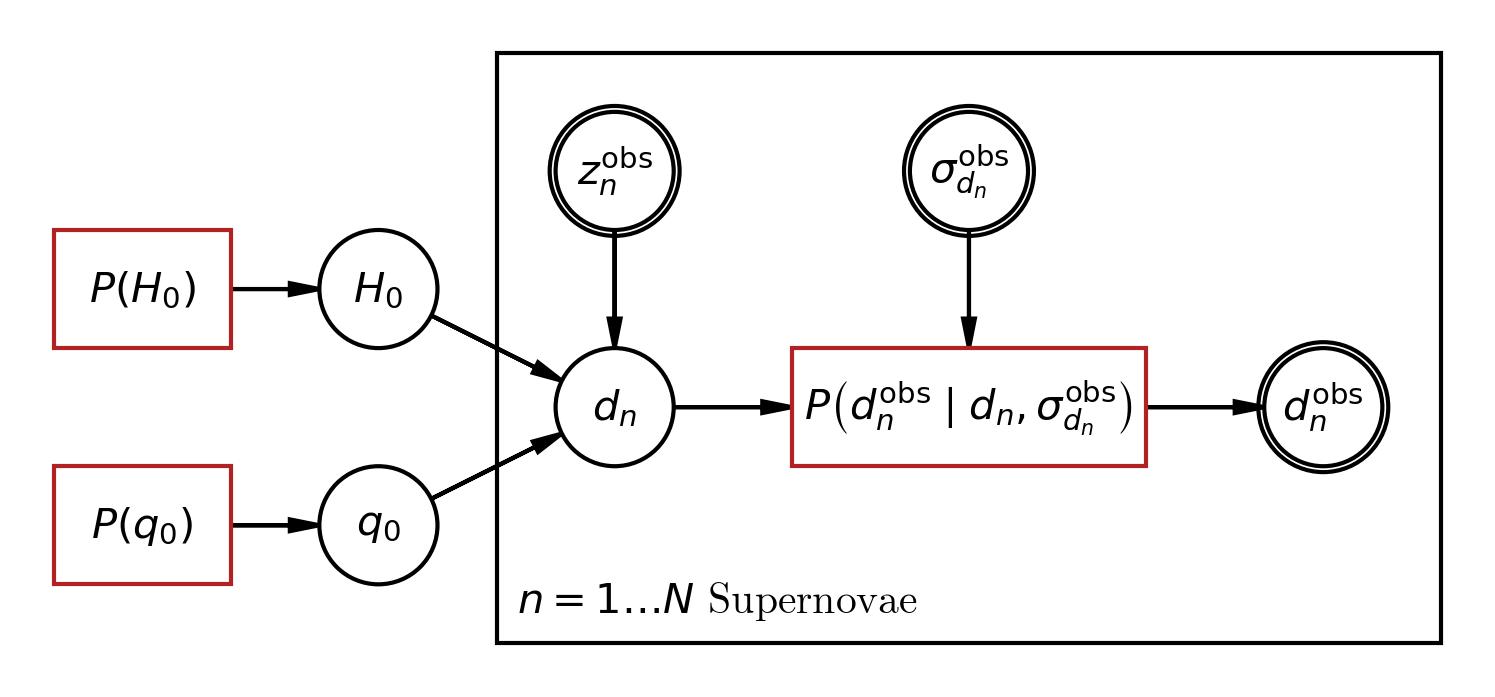

In [ ]:
import daft

pgm = daft.PGM(observed_style="outer")

pgm.add_node("P(H_0)", r"$P(H_0)$", -1, 4, shape="rectangle", aspect=1.5, plot_params={"ec":color_default})
pgm.add_node("H_0", r"$H_0$", 0, 4)
pgm.add_node("obs", r"$d^{\mathrm{obs}}_n$", 4, 3.5, observed=True)
pgm.add_node("err", r"$\sigma_{d_n}^\mathrm{obs}$", 2.5, 4.5, observed=True)
pgm.add_node("z", r"$z_{n}^\mathrm{obs}$", 1, 4.5, observed=True)
pgm.add_node("P(d_n|d)", r"$P\left(d^{\mathrm{obs}}_n\mid d_n, \sigma_{d_n}^\mathrm{obs}\right)$", 2.5, 3.5, scale=1, aspect=3.0, shape="rectangle", plot_params={"ec":color_default})
pgm.add_node("d", r"$d_n$", 1, 3.5)

pgm.add_node("P(q)", r"$P(q_0)$", -1, 3, shape="rectangle", aspect=1.5, plot_params={"ec":color_default})
pgm.add_node("q", r"$q_0$", 0, 3)

pgm.add_plate([0.5, 2.5, 4, 2.5], label=r"$n=1\ldots N$ Supernovae")

pgm.add_edge("P(H_0)", "H_0")
pgm.add_edge("H_0", "d")
pgm.add_edge("q", "d")
pgm.add_edge("z", "d")
pgm.add_edge("P(q)", "q")
pgm.add_edge("P(d_n|d)", "obs")
pgm.add_edge("err", "P(d_n|d)")
pgm.add_edge("d", "P(d_n|d)")

pgm.render(dpi=150);

The relevant distributions are asssumed to be as follows:
$$P(H_0) = \mathrm{Unif}(10., 100.)$$
$$P(q_0) = \mathrm{Unif}(-5, 5)$$
$$P\left(d^{\mathrm{obs}}_n\mid d\right) = \mathcal N\left(d^{\mathrm{obs}}_n\mid d_n, \sigma_{d_n}^\mathrm{obs}\right)$$

Defining the model in `Pyro` follows the above PGM closely
- Stochastic random variables are defined with `pyro.sample(name, distribution)`
- Deterministic variables are specified with `pyro.deterministic(name, expression)`
- Conditioning on observations is done using `pyro.sample(name, distribution, obs=observation)`
- Independence between random variables (plating) is specified using `pyro.plate`

In [ ]:
def model(x, y, yerr):
    """ Model definition in Pyro
    """
    
    # Stochastic nodes
    H0 = 100 * numpyro.sample("h0", dist.Uniform(0.1, 1.0))
    q0 = numpyro.sample("q0", dist.Uniform(0., 1.))
    
    # Deterministic node
    y_pred = numpyro.deterministic("y_pred", mu_pred_vmap(x, H0, q0) + 25.)
    
    # N different independent observations
    with numpyro.plate('observed_data', len(y)):
        return numpyro.sample("obs", dist.Normal(y_pred, yerr), obs=y)

Having defined the model, we can go on to perform inference on it. In an ideal world, we wouldn't have to think about this part at all---all of the "science" happens in the model definition (arguably). 

This is (unfortunately) not the casel however---choosing how to do inference on complex, high-dimensional models can be hard! Here are some examples using what's built in in `Pyro`:
- Hamiltonian Monte Carlo (HMC)
- Stochastic Variational Inference (SVI)

#### 2.3.2. Inference with Hamiltonian Monte Carlo (HMC)

- Markov Chain Monte Carlo (MCMC) algorithms let us sample from probability distributions---you've seen examples already and implemented the Metroplis-Hastings-[Rosenbluth](https://www.nytimes.com/2021/02/09/science/arianna-wright-dead.html) algorithm. Traditional MCMC algorithms can becomes increasingly inefficient when the parameter space of interest becomes high dimensional. 

- Hamiltonian Monte Carlo (HMC) is a variant of MCMC which uses likelihood _gradient_ information $\nabla_\theta\mathcal L$ in addition to the likelihood $\mathcal L$ and can scale much better to sampling from higher-dimensional distributions. Intuitively, it leverages the "momentum" of the likelihood function in addition to the "position".

- See [this page](https://chi-feng.github.io/mcmc-demo/app.html) for a cool demo and comparison of some sampling algorithms, including HMC and vanilla random walk Metropolis-Hastings.

In [ ]:
from IPython.display import IFrame
IFrame('https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=donut', width=750, height=500)

Since we've written down our model in a differentiable framework, we can easily run HMC on it. Now we're getting into _differentiable_ probabilistic programming.

In [ ]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=500)
rng_key = jax.random.PRNGKey(1)
mcmc.run(rng_key, zs, mm, dm)

sample: 100%|██████████| 2500/2500 [00:18<00:00, 133.79it/s, 3 steps of size 4.40e-01. acc. prob=0.94] 


In [ ]:
samples_hmc = {k: v for k, v in mcmc.get_samples().items()}
samples_hmc = np.array([samples_hmc['h0'] * 100, samples_hmc['q0']]).T

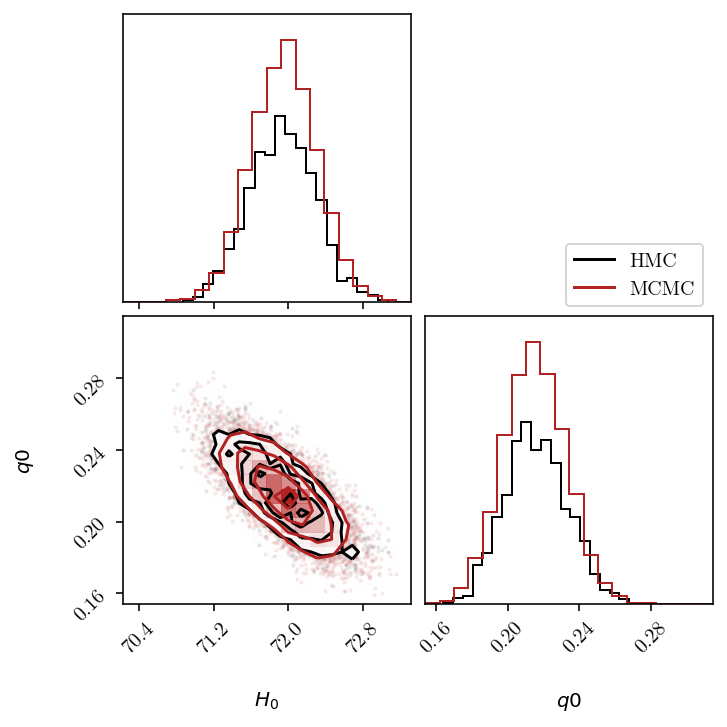

In [ ]:
import matplotlib.lines

figure = corner.corner(samples_hmc, labels=[r"$H_0$", r"$q0$"])
corner.corner(samples_emcee, fig=figure,weights=np.ones(len(samples_emcee)) / (len(samples_emcee) / len(samples_hmc)), color=color_default);

red_line = matplotlib.lines.Line2D([], [], color='firebrick', label='MCMC')
black_line = matplotlib.lines.Line2D([], [], color='k', label='HMC')

plt.legend(handles=[black_line, red_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

#### 2.3.3. Inference with Stochastic Variational Inference (SVI)

Other than obtaining samples from the posterior of interest, another method for approximating posterior distributions is to **optimize over a family of functions (called the _variational family_) such that the inferred distribution closely matches the actual posterior.**

The name comes from the _calculus of variations_, where infinitesimal changes to functionals (functions of functions, colloquially) are studied.

- In contrast to the MCMC-style approaches, this turns posterior inference into an optimization problem, rather than a sampling problem. 
- In contrast to the MLE approach (and the deep learning regression approach), rather than finding a single optimal set of parameter values (optimizing over possible numbers), we are now finding a single optimal _distribution_ (optimizing over possible functions).

Let's demonstrate this with plots, arbitrarily showing the "true" posterior as a t-distribution (just for schematic purposes).

In [ ]:
from scipy.stats import t, norm

# "True" distribution, just for schematic purposes
x = np.linspace(66, 74, 200)
post_fake = t.pdf(x, df=2, loc=np.mean(samples_emcee[:, 0]), scale=np.std(samples_emcee[:, 0]))

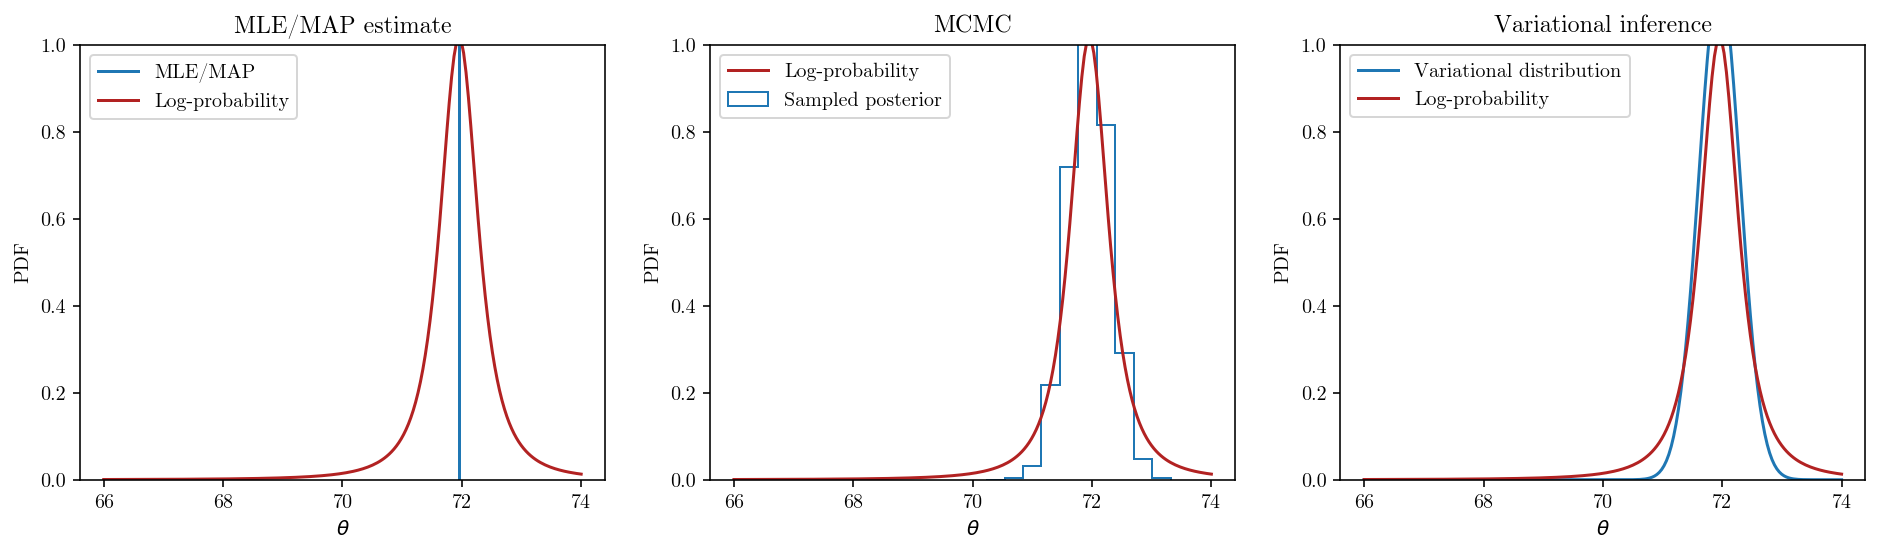

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,4))

ax[0].axvline(soln.x[0], label="MLE/MAP")
ax[0].plot(x, post_fake, color=color_default, label="Log-probability")
ax[0].set_title("MLE/MAP estimate")

ax[1].hist(samples_emcee[:, 0], histtype='step', density=True, label="Sampled posterior")
ax[1].plot(x, post_fake, color=color_default, label="Log-probability")
ax[1].set_title("MCMC")

# Arbitrarily-defined Gaussian approximation for the posterior
post_approx = norm.pdf(x, loc=np.mean(samples_emcee[:, 0]), scale=np.std(samples_emcee[:, 0]))
ax[2].plot(x, post_approx, label="Variational distribution")
ax[2].plot(x, post_fake, color=color_default, label="Log-probability")
ax[2].set_title("Variational inference")

[ax[i].set_xlabel(r"$\theta$") for i in range(3)]
[ax[i].set_ylabel(r"PDF") for i in range(3)]
[ax[i].set_ylim(0, 1) for i in range(3)]
[ax[i].legend(loc='upper left') for i in range(3)]

Here, we can borrow many of the optimization tricks from deep learning and efficiently scale to much higher dimensions and more complex likelihoods than is possible with sampling algorithms. In _stochastic_ variational inference, we use stochastic gradient descent to optimize over the variational family and target our desired posterior distribution.

We minimize the KL-divergence (a particular measure of closeness between distributions, also known as the "relative entropy") to arrive at the distribution that approximates our posterior well:

$$D_{\mathrm{KL}}(P \| Q)=\int p(x) \log \left(\frac{p(x)}{q(x)}\right) d x$$

with the integral being over the support of $P$. Let's compute $D_{\mathrm{KL}}(P \| Q)$ for a few different Gaussians, again `PyTorch` is doing all of the heavy lifting:

In [ ]:
p = torch.distributions.Normal(loc=1,scale=1)
q = torch.distributions.Normal(loc=1.2,scale=0.8)

kl = torch.distributions.kl.kl_divergence(p, q)

print("KL-divergence is {}".format(kl))

KL-divergence is 0.0893564522266388


In [ ]:
p = torch.distributions.Normal(loc=1,scale=1)
q = torch.distributions.Normal(loc=2.2,scale=0.8)

kl = torch.distributions.kl.kl_divergence(p, q)

print("KL-divergence is {}".format(kl))

KL-divergence is 1.1831064224243164


How do we do this without already knowing the posterior? While we can't minimize the KL-divergence directly, we can optimize another function that's equal to it up to a constant, called the Evidence Lower BOund (ELBO). This is abstracted away in `Pyro` and we won't go into details, but see [here](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf) or [here](https://mpatacchiola.github.io/blog/2021/01/25/intro-variational-inference.html) for details and a derivation of this objective function.

Now in addition to the model we need to define the variational family, in `Pyro` parlance known as a _guide_. Let's start with something simple---two different Gaussian distributions modeling the posteriors of the two parameters $H_0$ and $q$.

In [ ]:
def guide(x, y, yerr):
    """ A variational distribution defined by two uncorrelated Gaussians
    """
    
    # Means and standard deviations of Gaussians
    locs = numpyro.param("loc", 0.5 * jnp.ones(2))
    scales = numpyro.param("scales", 0.01 * jnp.ones(2), constraint=dist.constraints.positive)
    
    # Parameter samples from variational distribution
    h0 = numpyro.sample("h0", dist.Normal(locs[0], scales[0],))
    q0 = numpyro.sample("q0", dist.Normal(locs[1], scales[1],))

Now we can use the `Pyro` API to perform gradient descent on the guide parameters, in this case optimizing the means and stds of the two Gaussians.

In [ ]:
optimizer = numpyro.optim.Adam(0.01)
svi = SVI(model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), 3000, zs, mm, dm)
params = svi_results.params

100%|██████████| 3000/3000 [00:05<00:00, 584.73it/s, init loss: 5150.8753, avg. loss [2851-3000]: -101.1110]


After optimization, we can draw samples values from the guide to get a representative posterior. Note that since the modeled posterior in this case is quite simple (just two Gaussians) this could be done analytically. However in general for complex posteriors and high-dimensional distributions we need to sample.

Let's plot the samples and compare with what we got from `emcee`:

In [ ]:
from scipy.stats import norm

samples_svi = norm.rvs(svi_results.params['loc'], svi_results.params['scales'], size=(4000,2))
samples_svi[:, 0] *= 100.

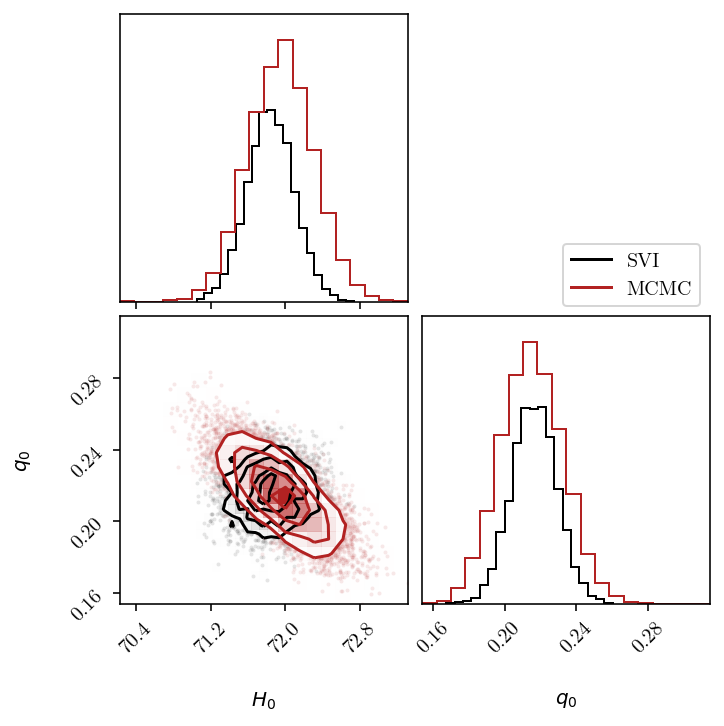

In [ ]:
import matplotlib.lines

figure = corner.corner(samples_svi, labels=[r"$H_0$", r"$q_0$"])
corner.corner(samples_emcee, fig=figure,weights=np.ones(len(samples_emcee)) / (len(samples_emcee) / len(samples_svi)), color=color_default);

red_line = matplotlib.lines.Line2D([], [], color='firebrick', label='MCMC')
black_line = matplotlib.lines.Line2D([], [], color='k', label='SVI')

plt.legend(handles=[black_line, red_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

**It looks like the SVI approach doesn't do a great job at modeling the posterior, assuming the MCMC samples to be representative!** Not too surprising perhaps---our variational distribution totally ignored correlations between the two parameters, which clearly exist (the joint posterior is a diagonal ellipse, meaning there are degeneracies between parameters).

Fortunately, we can do better. `Pyro` provides a nice interface for automatically generate variational distributions, called "autoguides". For example, we can use a multivariate normal distribution which additionally fits for the covariances between different parameters, as follows: 

In [ ]:
# Define a guide
guide = autoguide.AutoMultivariateNormal(model)

Let's do the optimization again with this guide, draw some samples and plot them.

In [ ]:
optimizer = numpyro.optim.Adam(0.01)
svi = SVI(model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), 2000, zs, mm, dm)
params = svi_results.params

100%|██████████| 2000/2000 [00:04<00:00, 474.57it/s, init loss: 527.2434, avg. loss [1901-2000]: -102.5907]


In [ ]:
samples_svi = guide.sample_posterior(rng_key=jax.random.PRNGKey(0), params=params, sample_shape=(2000,))
samples_svi = np.array([samples_svi['h0'] * 100, samples_svi['q0']]).T

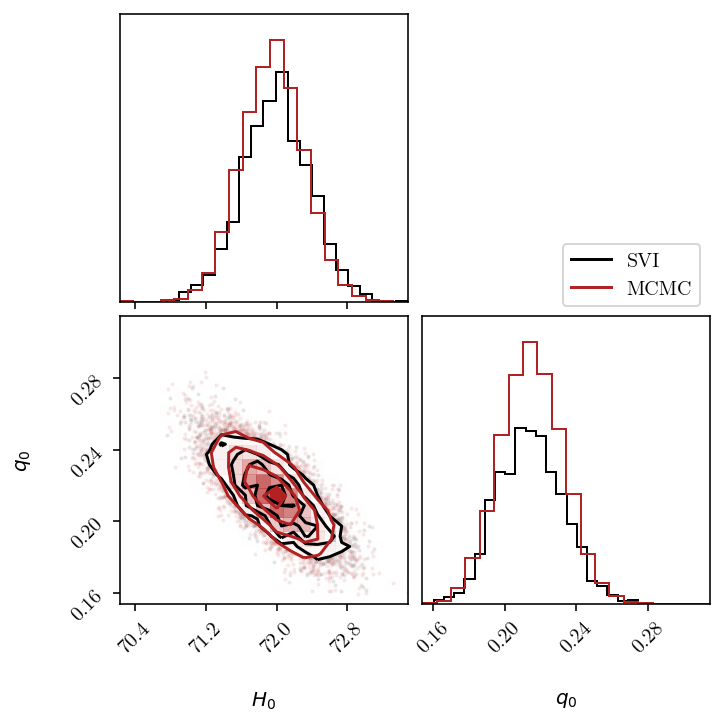

In [ ]:
figure = corner.corner(samples_svi, labels=[r"$H_0$", r"$q_0$"])
corner.corner(samples_emcee, fig=figure,weights=np.ones(len(samples_emcee)) / (len(samples_emcee) / len(samples_svi)), color=color_default);

red_line = matplotlib.lines.Line2D([], [], color='firebrick', label='MCMC')
black_line = matplotlib.lines.Line2D([], [], color='k', label='SVI')

plt.legend(handles=[black_line, red_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

This time the joint posterior is much closer to the MCMC ones, and we can see the covariances between the two components in action.